<a href="https://colab.research.google.com/github/vashishthaparth/music_generation/blob/main/music_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
  <h1 style="font-size: 36px; font-weight: bold;"><b>Music Generation</h1>

---



---



---


  <p style="font-size: 24px; font-weight: bold;"><i>(Generative AI)</p>
</center>



**Installing Necessary Libraries**

---



In [ ]:
!pip install pretty_midi

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


**Importing Libraries and Setup**

---



In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import os

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

_SAMPLING_RATE = 16000

**Mounting Google Drive to Google Colab**


---





In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Loading the Dataset**

---



In [ ]:
data_dir = pathlib.Path('/content/drive/My Drive/midi')

# Ensure the directory exists
if not data_dir.exists():
    raise FileNotFoundError(f"The directory {data_dir} does not exist")

# Get the list of MIDI files
mid_filenames = glob.glob(str(data_dir / '*.mid'))
midi_filenames = glob.glob(str(data_dir / '*.midi'))

# Combine both lists
filenames = midi_filenames + mid_filenames

print('Number of files:', len(filenames))

Number of files: 1453


**Process a MIDI file**

---



In [ ]:
sample_file = filenames[1]
print(sample_file)

/content/drive/My Drive/midi/MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--5.midi


**Generate a PrettyMIDI object for the sample MIDI file.**

---



In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file)

**Playing** **Sample** **Music**

---



In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short,rate=_SAMPLING_RATE)

`By Deafult MIDI files store music in piano notes`



In [ ]:
display_audio(pm)

**Determining Information of MIDI File**

---



In [ ]:
print('No. of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print("Instrument name:", instrument_name)

No. of instruments: 1
Instrument name: Acoustic Grand Piano


**Extracting Notes**

---



In [ ]:
for i, note in enumerate(instrument.notes[:60]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration=(duration:.4f)')

0: pitch=29, note_name=F1, duration=(duration:.4f)
1: pitch=41, note_name=F2, duration=(duration:.4f)
2: pitch=48, note_name=C3, duration=(duration:.4f)
3: pitch=56, note_name=G#3, duration=(duration:.4f)
4: pitch=60, note_name=C4, duration=(duration:.4f)
5: pitch=36, note_name=C2, duration=(duration:.4f)
6: pitch=61, note_name=C#4, duration=(duration:.4f)
7: pitch=48, note_name=C3, duration=(duration:.4f)
8: pitch=56, note_name=G#3, duration=(duration:.4f)
9: pitch=68, note_name=G#4, duration=(duration:.4f)
10: pitch=62, note_name=D4, duration=(duration:.4f)
11: pitch=60, note_name=C4, duration=(duration:.4f)
12: pitch=72, note_name=C5, duration=(duration:.4f)
13: pitch=68, note_name=G#4, duration=(duration:.4f)
14: pitch=63, note_name=D#4, duration=(duration:.4f)
15: pitch=75, note_name=D#5, duration=(duration:.4f)
16: pitch=60, note_name=C4, duration=(duration:.4f)
17: pitch=62, note_name=D4, duration=(duration:.4f)
18: pitch=48, note_name=C3, duration=(duration:.4f)
19: pitch=60, n

In [ ]:
def midi_to_notes(midi_files: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_files)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end-start)
    prev_start =  start


  return pd.DataFrame({name:np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,29,0.973958,1.113281,0.000000,0.139323
1,41,1.006510,1.134115,0.032552,0.127604
2,56,1.088542,1.265625,0.082031,0.177083
3,48,1.197917,1.246094,0.109375,0.048177
4,60,1.289062,1.326823,0.091146,0.037760


**Labeling Pitches as Notes Annotations**

---



In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['F1', 'F2', 'G#3', 'C3', 'C4', 'C3', 'C2', 'C#4', 'G#3', 'G#4'],
      dtype='<U3')

**Generating MIDI thorugh Notes Which We Generated Through MIDI File.**

---



In [ ]:
def notes_to_midi(
    notes: pd.DataFrame,
    out_file: str,
    instrument_name: str,
    velocity: int = 100,
)   -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
      start = float(prev_start + note['step'])
      end = float(start + note['duration'])
      note = pretty_midi.Note(
          velocity=velocity,
          pitch=int(note['pitch']),
          start = start,
          end = end,
      )
      instrument.notes.append(note)
      prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file = example_file, instrument_name = instrument_name)

In [ ]:
display_audio(example_pm)

**Create Training Dataset**

---



In [ ]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes period', n_notes)

Number of notes period 16895


In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis = 1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

**Function to Create Sequences for Training a Model**

---



In [ ]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.5546875  0.         1.48567708]
 [0.40625    0.09244792 0.27473958]
 [0.5234375  1.3828125  0.19140625]
 [0.4609375  0.01171875 0.17057292]
 [0.5        0.0078125  0.15625   ]
 [0.5546875  0.45703125 0.19661458]
 [0.5234375  0.05989583 0.07291667]
 [0.5        0.0078125  0.07552083]
 [0.4609375  0.01302083 0.07291667]
 [0.5546875  0.39713542 0.125     ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=76.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.4309895833333339>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.6119791666666661>}


In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

**Create and Train the Model**

---



In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)

# Adding more hidden layers and making them more complex
x = tf.keras.layers.LSTM(128, return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.LSTM(128)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)

outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
    'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 25, 128)              67584     ['input_1[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               (None, 25, 128)              131584    ['lstm[0][0]']                
                                                                                                  
 lstm_2 (LSTM)               (None, 128)                  131584    ['lstm_1[0][0]']              
                                                                                              

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

263/263 [==============================] - 26s 74ms/step - loss: 5.3967 - duration_loss: 0.4225 - pitch_loss: 4.8518 - step_loss: 0.1224


{'loss': 5.396717071533203,
 'duration_loss': 0.42250722646713257,
 'pitch_loss': 4.851846694946289,
 'step_loss': 0.12236172705888748}

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

263/263 [==============================] - 22s 69ms/step - loss: 0.7875 - duration_loss: 0.4225 - pitch_loss: 4.8518 - step_loss: 0.1224


{'loss': 0.7874611616134644,
 'duration_loss': 0.42250722646713257,
 'pitch_loss': 4.851846694946289,
 'step_loss': 0.12236172705888748}

**Train the Model**

---



In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True,
        save_freq='epoch',  # Save weights every epoch
        verbose=1),  # Show verbose output
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
    263/Unknown - 58s 194ms/step - loss: 0.3225 - duration_loss: 0.1010 - pitch_loss: 3.9071 - step_loss: 0.0262
Epoch 1: saving model to ./training_checkpoints/ckpt_1
263/263 [==============================] - 59s 196ms/step - loss: 0.3225 - duration_loss: 0.1010 - pitch_loss: 3.9071 - step_loss: 0.0262
Epoch 2/50
263/263 [==============================] - ETA: 0s - loss: 0.3145 - duration_loss: 0.0999 - pitch_loss: 3.7974 - step_loss: 0.0247
Epoch 2: saving model to ./training_checkpoints/ckpt_2
263/263 [==============================] - 49s 186ms/step - loss: 0.3145 - duration_loss: 0.0999 - pitch_loss: 3.7974 - step_loss: 0.0247
Epoch 3/50
263/263 [==============================] - ETA: 0s - loss: 0.3121 - duration_loss: 0.0975 - pitch_loss: 3.7930 - step_loss: 0.0249
Epoch 3: saving model to ./training_checkpoints/ckpt_3
263/263 [==============================] - 45s 173ms/step - loss: 0.3121 - duration_loss: 0.0975 - pitch_loss: 3.7930 - step_loss: 0.0249
Epoch 4/50
26

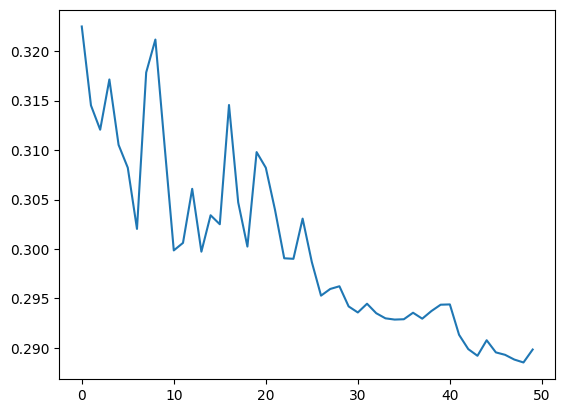

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

**Generating New Notes**

---



In [ ]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.0
num_predictions = 1200

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 59ms/step


In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,63,0.094265,0.142761,0.094265,0.237026
1,81,0.160400,0.319794,0.254665,0.574459
2,82,0.118873,0.208645,0.373537,0.582182
3,59,0.121737,0.216312,0.495275,0.711587
4,70,0.115457,0.199503,0.610732,0.810234
5,62,0.121593,0.215926,0.732325,0.948251
6,43,0.117292,0.204414,0.849617,1.054031
7,69,0.099080,0.155669,0.948696,1.104366
8,29,0.126462,0.228959,1.075159,1.304118
9,68,0.092663,0.138084,1.167822,1.305905


**Playing Generated Music**

---



In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)